### 1. Φόρτωση και Προετοιμασία Δεδομένων
- Καθορίζονται τα paths για τα train/test δεδομένα από το dataset `chest_xray`.
- Χρησιμοποιείται `ImageDataGenerator` για:
  - **Κανονικοποίηση** των pixel values (rescale).
  - **Data augmentation** (μόνο στο training set): περιστροφή, zoom, οριζόντια αναστροφή.
  - **Split**: το 10% των training δεδομένων κρατείται ως validation set.
- Δημιουργούνται οι generators `train_generator`, `val_generator`, `test_generator`.

### 2. Υπολογισμός Class Weights
- Χρησιμοποιείται `compute_class_weight()` για να αντιμετωπιστεί η **ανισορροπία κλάσεων** (Normal vs Pneumonia).
- Δημιουργείται λεξικό `class_weights_dict` που χρησιμοποιείται στην εκπαίδευση.

### 3. Ορισμός Μοντέλου με Hyperparameter Tuning
- Χρησιμοποιείται το εργαλείο
  **Keras Tuner** για αυτόματο πειραματισμό με:
  - Αριθμό φίλτρων στα `Conv2D` layers.
  - Μέγεθος του `Dense` layer.
  - Ποσοστό `Dropout`.
  - Τιμή `learning_rate`.
- Το μοντέλο είναι `Sequential` και καταλήγει σε `sigmoid` για binary classification.

### 4. Εκτέλεση Hyperparameter Search
- Ορίζεται `kt.RandomSearch` με `max_trials=5` για να δοκιμαστούν 5 παραλλαγές του μοντέλου.
- Εκπαίδευση κάθε μοντέλου για 10 εποχές με στόχο την `val_accuracy`.
- Χρησιμοποιείται `EarlyStopping` για να αποφευχθεί overfitting και σπατάλη χρόνου.

### 5. Ανάκτηση Βέλτιστων Υπερπαραμέτρων
- Γίνεται ανάκτηση των καλύτερων υπερπαραμέτρων μέσω `tuner.get_best_hyperparameters()`.
- Εκτυπώνονται οι τιμές για τεκμηρίωση.

### 6. Τελική Εκπαίδευση του Καλύτερου Μοντέλου
- Το καλύτερο μοντέλο (`best_model`) εκπαιδεύεται περαιτέρω για έως 20 εποχές με:
  - `ReduceLROnPlateau`: Μειώνει το learning rate όταν το validation loss σταθεροποιείται.
  - `EarlyStopping`: Σταματά την εκπαίδευση αν δεν υπάρχει βελτίωση, και επαναφέρει τα καλύτερα βάρη (`restore_best_weights=True`).
  - Χρήση `class_weights_dict` για επιπλέον ισορροπία κατά την εκπαίδευση. θα χρειαζόταν για χειροκίνητη ρύθμιση.


In [1]:
import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import os
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")
import kagglehub
from keras.metrics import AUC
import shutil
import random
from tensorflow.keras.models import load_model


In [2]:
random.seed(42)
import random
import tensorflow as tf

seed = 42
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)



dataset_path= '/Users/theodosiavidalaki/Downloads/chest_xray'
new_dataset_path = '/Users/theodosiavidalaki/Downloads/chest_xraydokimas'
for split in ['train', 'val', 'test']:
   for cls in ['NORMAL', 'PNEUMONIA']:
       os.makedirs(f'{new_dataset_path}/{split}/{cls}', exist_ok=True)

for cls in ['NORMAL', 'PNEUMONIA']:
   all_files = []
   for split in ['train', 'val', 'test']:
       source_folder = f'{dataset_path}/{split}/{cls}'

       files = sorted(os.listdir(source_folder))
       files = [f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

       all_files.extend([(file, source_folder) for file in files])

   
   random.shuffle(all_files)

   train_files = all_files[:int(len(all_files)*0.8)]
   val_files = all_files[int(len(all_files)*0.8):int(len(all_files)*0.9)]
   test_files = all_files[int(len(all_files)*0.9):]

   for file, source_folder in train_files:
       dest = f'{new_dataset_path}/train/{cls}/{file}'
       shutil.copy(f'{source_folder}/{file}', dest)

   for file, source_folder in val_files:
       dest = f'{new_dataset_path}/val/{cls}/{file}'
       shutil.copy(f'{source_folder}/{file}', dest)

   for file, source_folder in test_files:
       dest = f'{new_dataset_path}/test/{cls}/{file}'
       shutil.copy(f'{source_folder}/{file}', dest)  
import pandas as pd

data = []

for split in ['train', 'val', 'test']:
    for cls in ['NORMAL', 'PNEUMONIA']:
        folder = os.path.join(new_dataset_path, split, cls)
        count = len(os.listdir(folder))
        data.append({'Split': split, 'Class': cls, 'Images': count})

df = pd.DataFrame(data)
print(df) ## ΤΕΛΙΚΟΣ ΧΩΡΙΣΜΟΣ ΜΕΤΑ ΑΠΟ ΕΠΕΞΕΡΓΑΣΙΑ ##
data_old=[]
## ΑΡΧΙΚΟΣ ΧΩΡΙΣΜΟΣ ΕΙΚΟΝΩΝ ΣΕ ΣΑΜΠΣΕΤΣ ##
for cls in ['NORMAL', 'PNEUMONIA']:
    for split in ['train', 'val', 'test']:
        folder1 = f"{dataset_path}/{split}/{cls}"
        count = len(os.listdir(folder1))
        data_old.append({'split': split, 'class': cls, 'count': count})

df1 = pd.DataFrame(data_old)
print(df1) ##### TSEK ####

   Split      Class  Images
0  train     NORMAL    1266
1  train  PNEUMONIA    3418
2    val     NORMAL     158
3    val  PNEUMONIA     427
4   test     NORMAL     159
5   test  PNEUMONIA     428
   split      class  count
0  train     NORMAL   1341
1    val     NORMAL      8
2   test     NORMAL    234
3  train  PNEUMONIA   3875
4    val  PNEUMONIA      8
5   test  PNEUMONIA    390


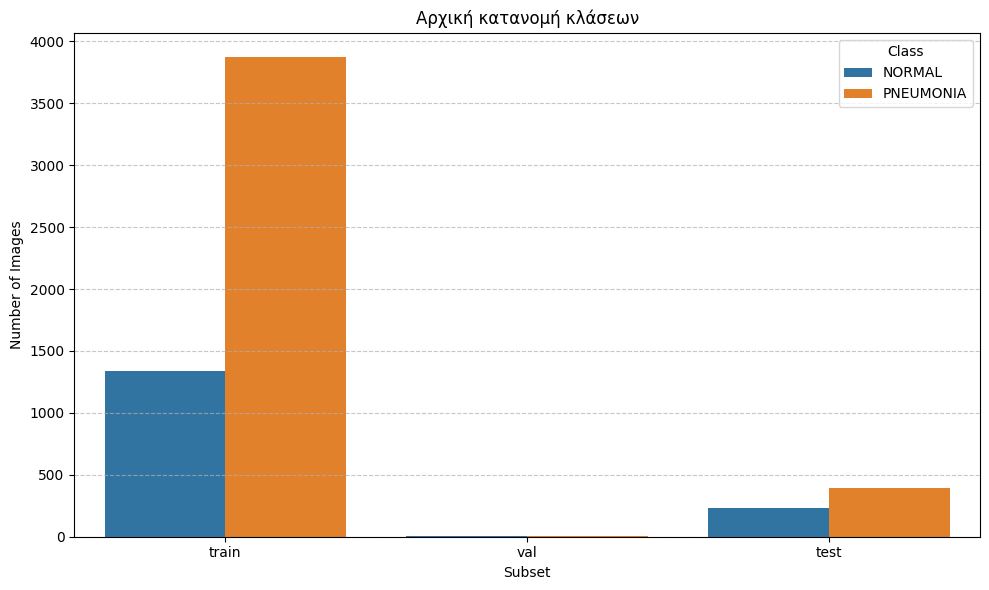

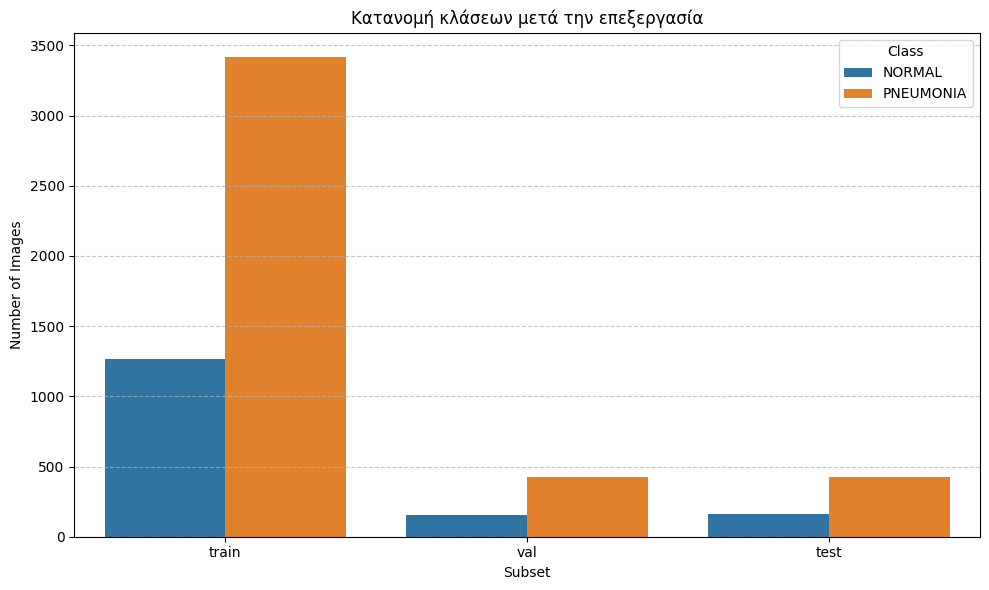

In [3]:
def plot_class_distribution(base_path, title="Κατανομή κλάσεων"):
    data = {'Split': [], 'Class': [], 'Count': []}
    
    for split in ['train', 'val', 'test']:
        for cls in ['NORMAL', 'PNEUMONIA']:
            folder = os.path.join(base_path, split, cls)
            count = len(os.listdir(folder))
            data['Split'].append(split)
            data['Class'].append(cls)
            data['Count'].append(count)

    df = pd.DataFrame(data)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x='Split', y='Count', hue='Class', data=df)
    plt.title(title)
    plt.xlabel("Subset")
    plt.ylabel("Number of Images")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# 🔹 Κλήση για αρχική κατανομή
plot_class_distribution('/Users/theodosiavidalaki/Downloads/chest_xray', title="Αρχική κατανομή κλάσεων")

# 🔹 Κλήση για νέα κατανομή (αν έχεις κάνει balancing)
plot_class_distribution('/Users/theodosiavidalaki/Downloads/chest_xraydokimas', title="Κατανομή κλάσεων μετά την επεξεργασία")


In [4]:
if os.path.exists('kt_dir'):
    shutil.rmtree('kt_dir')
IMG_SIZE = 150
BATCH_SIZE = 32
EPOCHS = 20

base_dir = new_dataset_path
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
val_dir = os.path.join(base_dir, "val")


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

y_train = train_generator.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = dict(enumerate(class_weights))
print("Class Weights:", class_weights_dict)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

num_train = train_generator.samples
num_val = val_generator.samples
num_test = test_generator.samples

total = num_train + num_val + num_test

print(f"Train samples: {num_train}")
print(f"Validation samples: {num_val}")
print(f"Test samples: {num_test}")
print(f"Total samples in dataset: {total}")

from collections import Counter

print("Train class distribution:", Counter(train_generator.classes))
print("Validation class distribution:", Counter(val_generator.classes))
print("Test class distribution:", Counter(test_generator.classes))


Found 4684 images belonging to 2 classes.
Class Weights: {0: 1.8499210110584519, 1: 0.6851960210649503}
Found 585 images belonging to 2 classes.
Found 587 images belonging to 2 classes.
Train samples: 4684
Validation samples: 585
Test samples: 587
Total samples in dataset: 5856
Train class distribution: Counter({1: 3418, 0: 1266})
Validation class distribution: Counter({1: 427, 0: 158})
Test class distribution: Counter({1: 428, 0: 159})


In [5]:
warnings.filterwarnings('ignore')
# Ορισμός μοντέλου για Keras Tuner
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(
        filters=hp.Int('conv1_filters', min_value=16, max_value=64, step=16),
        kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv2_filters', min_value=32, max_value=128, step=32),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(
        filters=hp.Int('conv3_filters', min_value=64, max_value=256, step=64),
        kernel_size=(3,3), activation='relu'
    ))
    model.add(MaxPooling2D(2,2))
    
    model.add(Flatten())
    
    model.add(Dense(
        units=hp.Int('dense_units', min_value=64, max_value=256, step=64),
        activation='relu'
    ))
    
    model.add(Dropout(hp.Float('dropout_rate', 0.3, 0.7, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-5, 1e-3, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Found 585 images belonging to 2 classes.


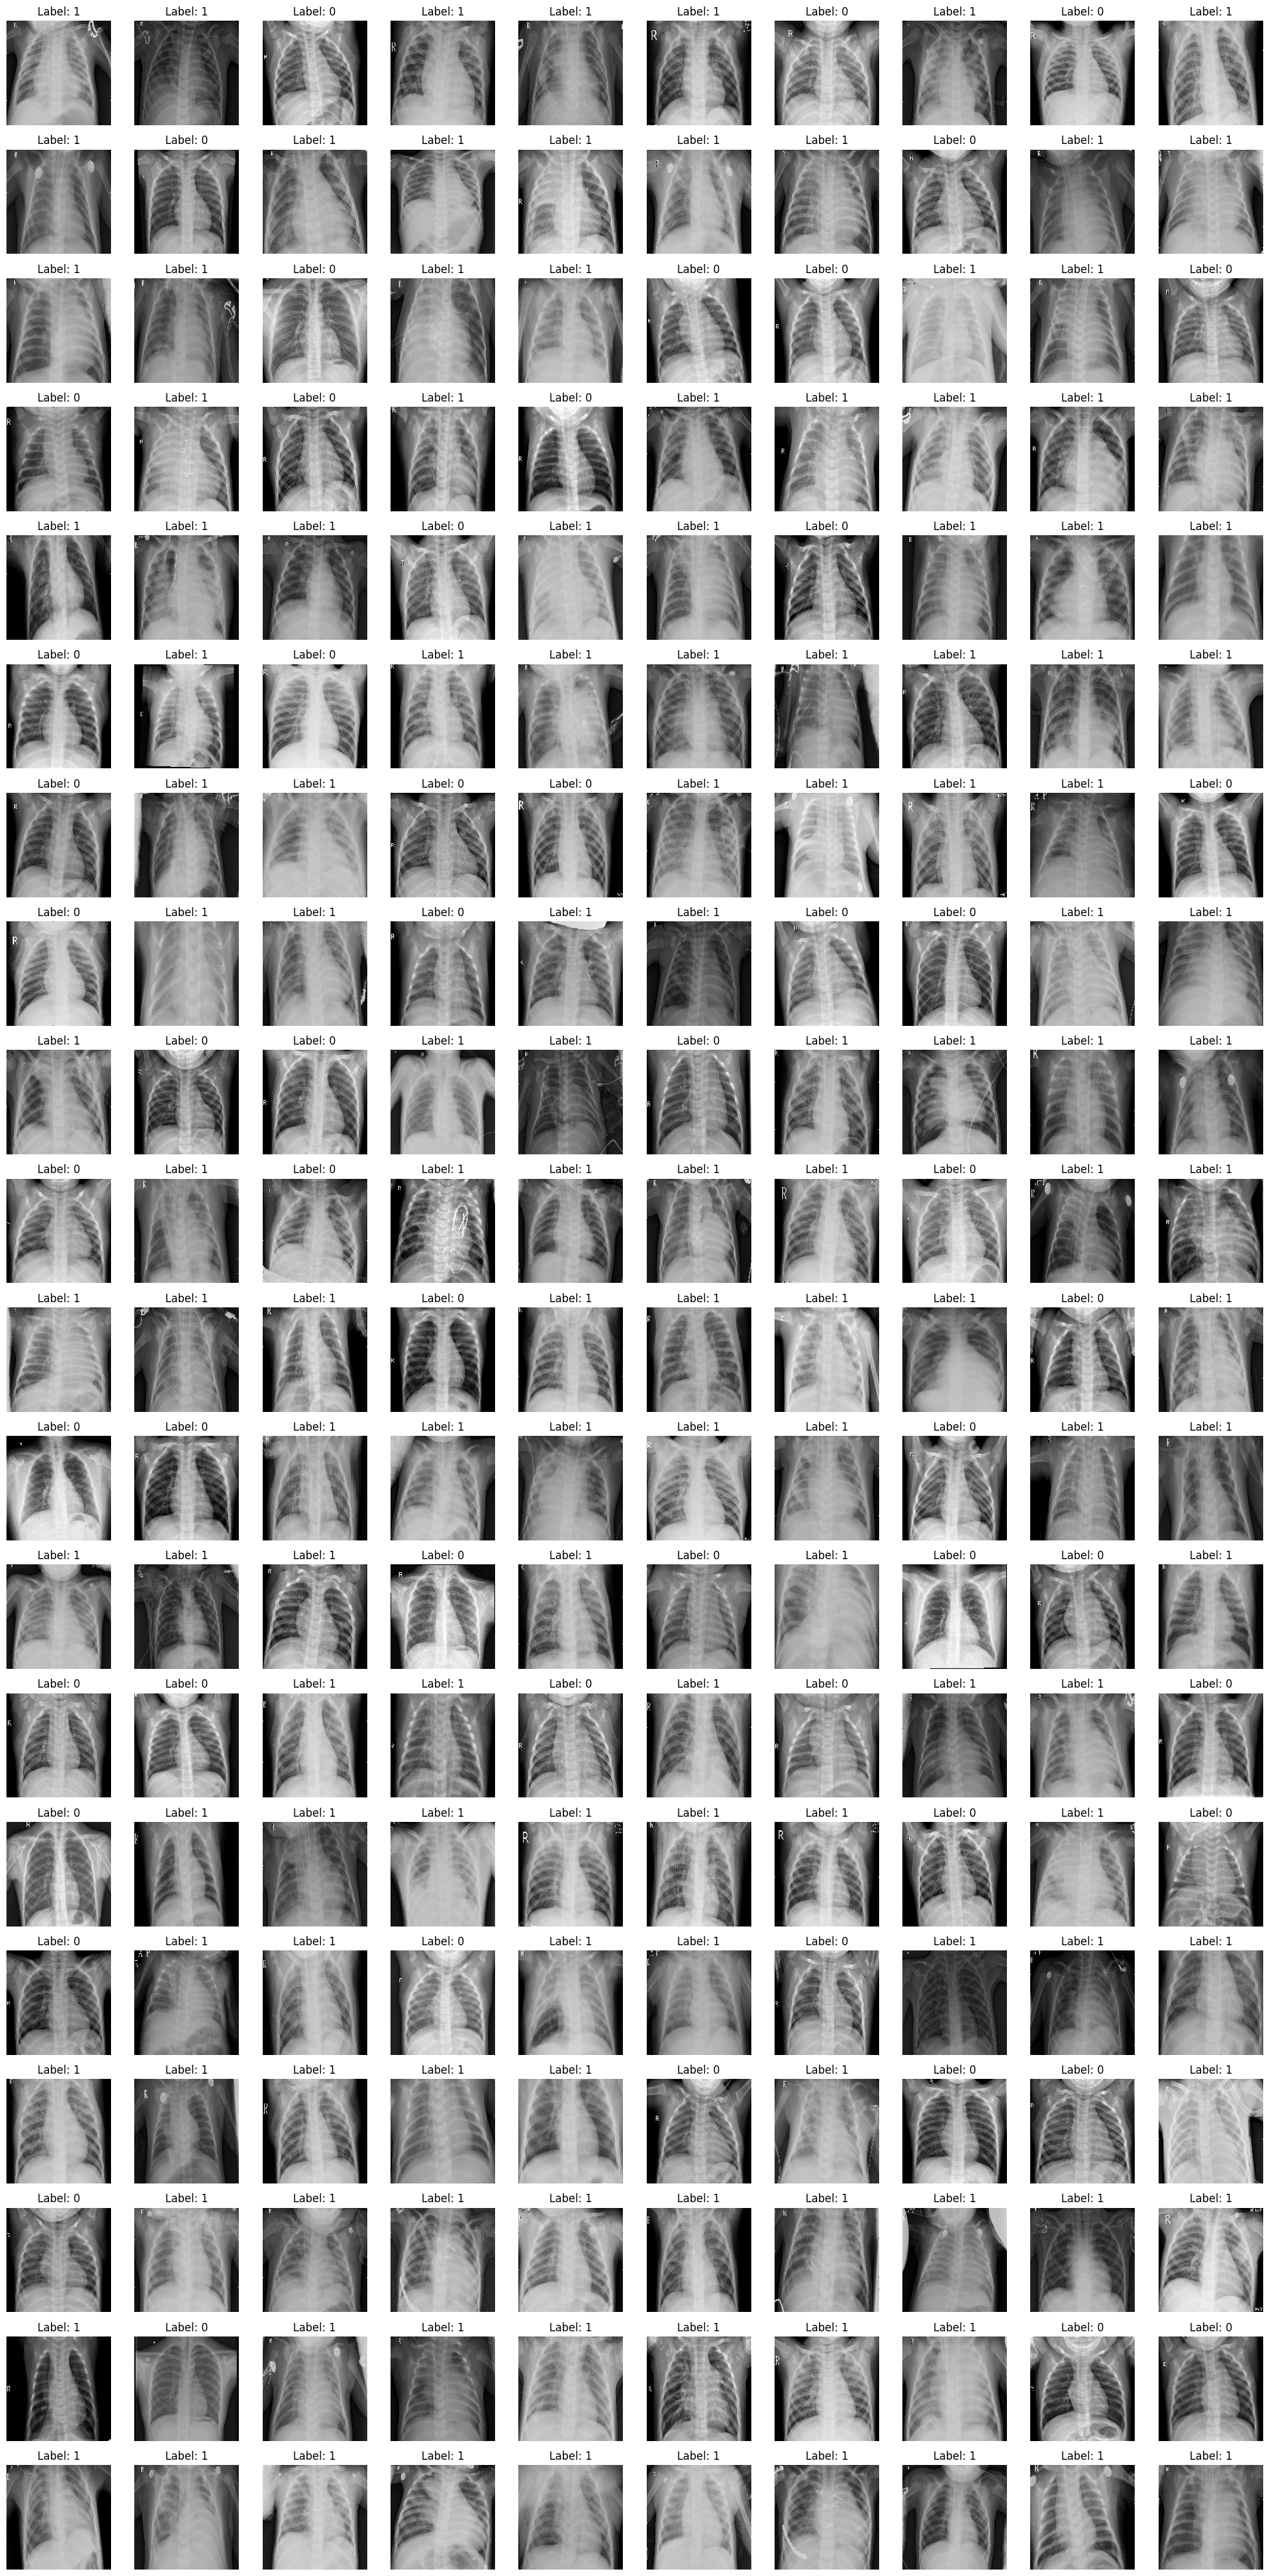

In [6]:
## mono gia na deiksoume ##
val_vis_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)
# Πάρε 200 εικόνες από τον generator
X_val = []
Y_val = []

val_generator.reset()  # Επανεκκίνηση generator
for i in range(7):  # 7 batches x 32 ≈ 224 εικόνες
    x_batch, y_batch = next(val_vis_generator)
    X_val.append(x_batch)
    Y_val.append(y_batch)

X_val = np.concatenate(X_val)[:200]
Y_val = np.concatenate(Y_val)[:200]

# Πλοκή 200 εικόνων
plt.figure(figsize=(20, 40))
for i in range(200):
    plt.subplot(20, 10, i+1)
    plt.imshow(X_val[i])
    plt.title(f"Label: {int(Y_val[i])}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [11]:
# Δημιουργία tuner
warnings.filterwarnings('ignore')

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_accuracy', direction='max'),
    max_trials=8,
    executions_per_trial=1,
    directory='kt_dir',
    project_name='pneumonia_tuning',
    seed=42
)

# Αναζήτηση καλύτερων hyperparameters
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)


# Παίρνουμε το καλύτερο μοντέλο
best_model = tuner.get_best_models(num_models=1)[0]
best_hps = tuner.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps.values)

# Μπορείς να εκπαιδεύσεις το καλύτερο μοντέλο για περισσότερα epochs
history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2), EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)]
)


Trial 8 Complete [00h 03m 33s]
val_accuracy: 0.9213675260543823

Best val_accuracy So Far: 0.9470085501670837
Total elapsed time: 00h 26m 46s
Best hyperparameters:
{'conv1_filters': 48, 'conv2_filters': 32, 'conv3_filters': 128, 'dense_units': 64, 'dropout_rate': 0.6000000000000001, 'learning_rate': 0.0001715074355925934}
Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 25s 164ms/step - accuracy: 0.8639 - loss: 0.3914 - val_accuracy: 0.9350 - val_loss: 0.1664 - learning_rate: 1.7151e-04
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 151ms/step - accuracy: 0.8918 - loss: 0.3107 - val_accuracy: 0.9538 - val_loss: 0.1376 - learning_rate: 1.7151e-04
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.9075 - loss: 0.2497 - val_accuracy: 0.9453 - val_loss: 0.1708 - learning_rate: 1.7151e-04
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 22s 150ms/step - accuracy: 0.9078 - loss: 0.2579 - val_accuracy: 0.9556 - val_loss: 0.1380 - learning_rate: 1.7151e-04
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
best_model.save("best_pneumonia_model.keras")

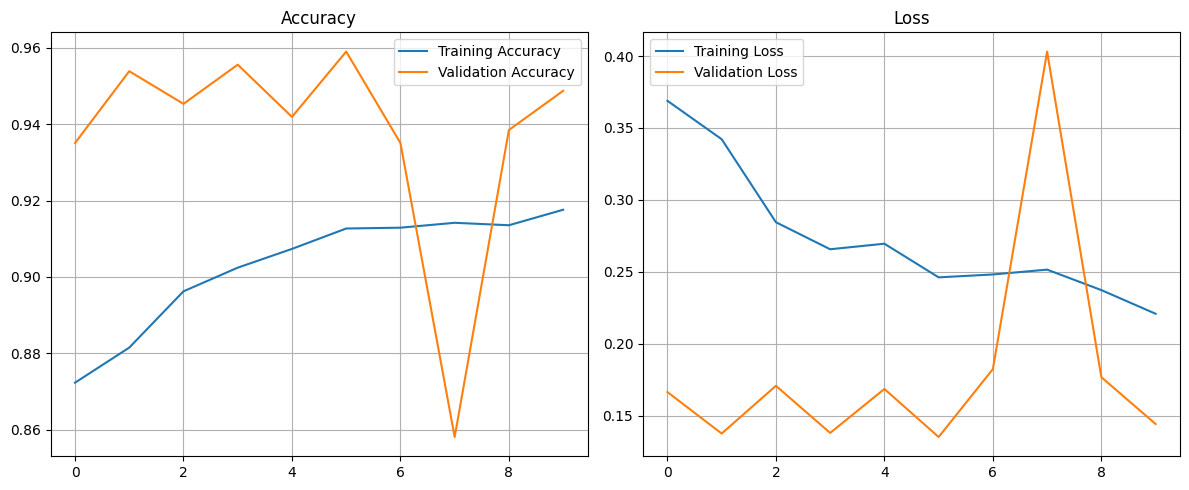

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()

In [17]:
print("Running evaluation...")
test_loss, test_accuracy = best_model.evaluate(test_generator, verbose=1)


Running evaluation...
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - accuracy: 0.9373 - loss: 0.1665


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step

BBest Threshold based on F1 Score: 0.27

Classification Report:
               precision    recall  f1-score   support

      Normal       0.90      0.91      0.91       159
   Pneumonia       0.97      0.96      0.96       428

    accuracy                           0.95       587
   macro avg       0.93      0.94      0.94       587
weighted avg       0.95      0.95      0.95       587



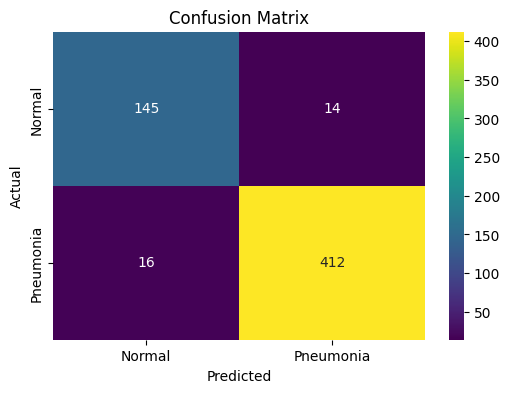

In [19]:
model = load_model("best_pneumonia_model.keras")

# Προβλέψεις
test_generator.reset()
preds = model.predict(test_generator, verbose=1)
y_true = test_generator.classes

# Υπολογισμός precision, recall, f1 για διάφορα thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred = (preds > t).astype(int).reshape(-1)
    precisions.append(precision_score(y_true, y_pred))
    recalls.append(recall_score(y_true, y_pred))
    f1s.append(f1_score(y_true, y_pred))

# Βρίσκουμε το threshold που μεγιστοποιεί το F1
best_index = np.argmax(f1s)
best_threshold = thresholds[best_index]
print(f"\nBBest Threshold based on F1 Score: {best_threshold:.2f}")

# Χρησιμοποιούμε αυτό το threshold
y_pred = (preds > best_threshold).astype(int).reshape(-1)

# Εμφάνιση classification report και confusion matrix
print("\nClassification Report:\n", classification_report(y_true, y_pred, target_names=["Normal", "Pneumonia"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


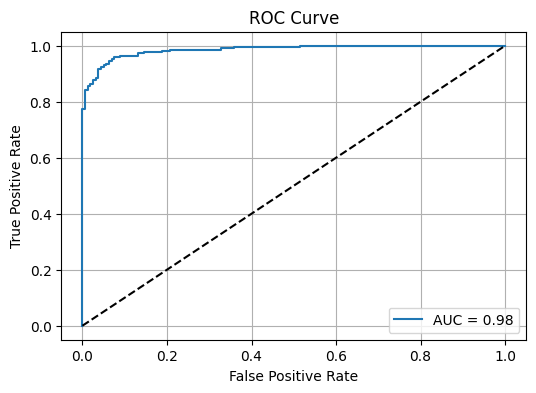

In [20]:
# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_true, preds)
roc_auc = roc_auc_score(y_true, preds)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

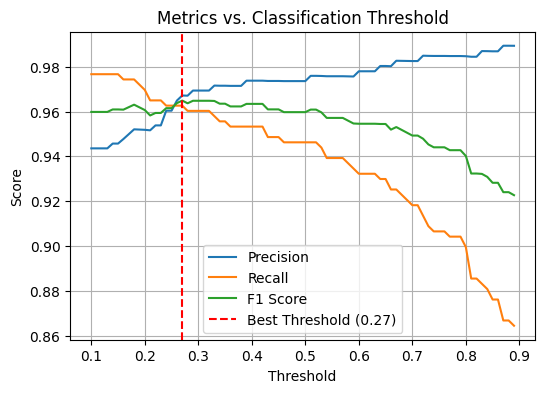

In [21]:
# Γράφημα Precision/Recall/F1 vs Threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

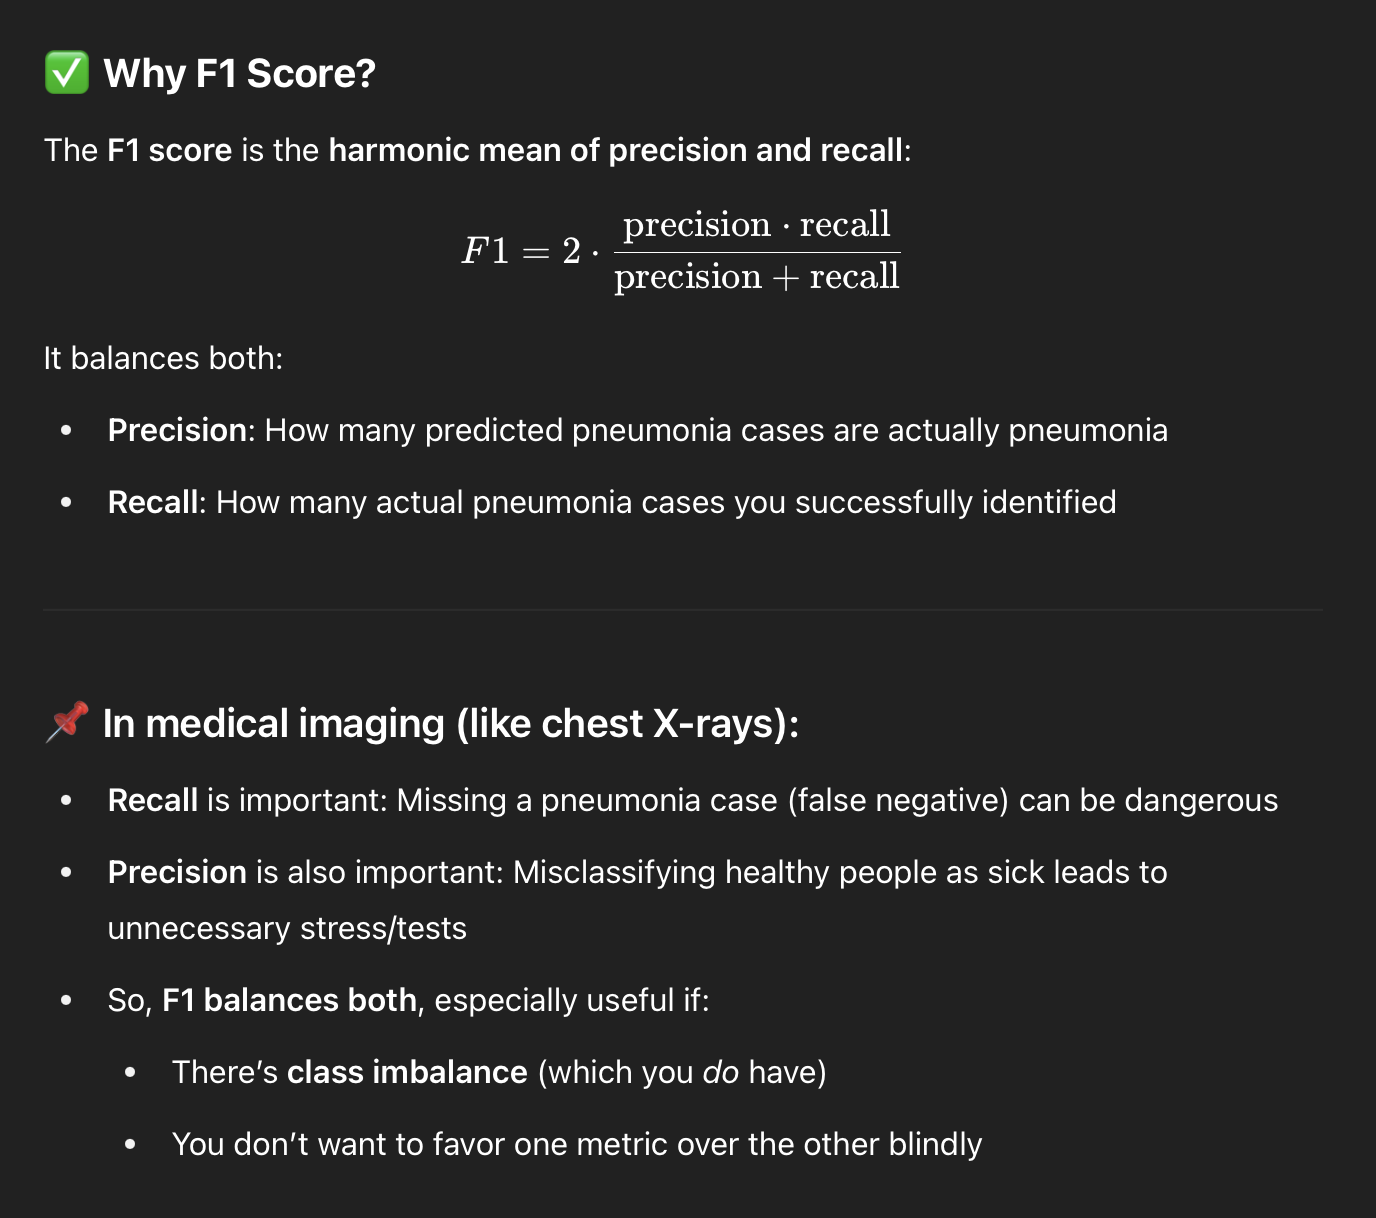

In [23]:
warnings.filterwarnings('ignore')

tuner1 = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy',direction='max'),
    max_trials=8, 
    executions_per_trial=1,
    directory='kt_dir_bayes',
    project_name='pneumonia_bayes_tuning'
)

tuner1.search(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    class_weight=class_weights_dict,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)]
)

# Καλύτερο μοντέλο & υπερπαράμετροι
best_model1 = tuner1.get_best_models(num_models=1)[0]
best_hps1 = tuner1.get_best_hyperparameters(1)[0]

print("Best hyperparameters:")
print(best_hps1.values)

history1 = best_model1.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    class_weight=class_weights_dict,
    callbacks=[
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2),
        EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
    ]

)

Reloading Tuner from kt_dir_bayes/pneumonia_bayes_tuning/tuner0.json
Best hyperparameters:
{'conv1_filters': 16, 'conv2_filters': 128, 'conv3_filters': 256, 'dense_units': 256, 'dropout_rate': 0.5, 'learning_rate': 0.0003610323940298591}
Epoch 1/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 24s 161ms/step - accuracy: 0.9023 - loss: 0.2615 - val_accuracy: 0.9521 - val_loss: 0.1303 - learning_rate: 3.6103e-04
Epoch 2/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.9261 - loss: 0.1874 - val_accuracy: 0.9538 - val_loss: 0.1260 - learning_rate: 3.6103e-04
Epoch 3/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 157ms/step - accuracy: 0.9187 - loss: 0.1939 - val_accuracy: 0.9573 - val_loss: 0.1227 - learning_rate: 3.6103e-04
Epoch 4/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.9168 - loss: 0.2114 - val_accuracy: 0.9590 - val_loss: 0.1133 - learning_rate: 3.6103e-04
Epoch 5/30
147/147 ━━━━━━━━━━━━━━━━━━━━ 23s 155ms/step - accuracy: 0.9360 - loss: 0.1704 - val_accuracy: 0.9521 - val_loss: 0.

In [24]:
best_model1.save("best_pneumonia_model1.keras")

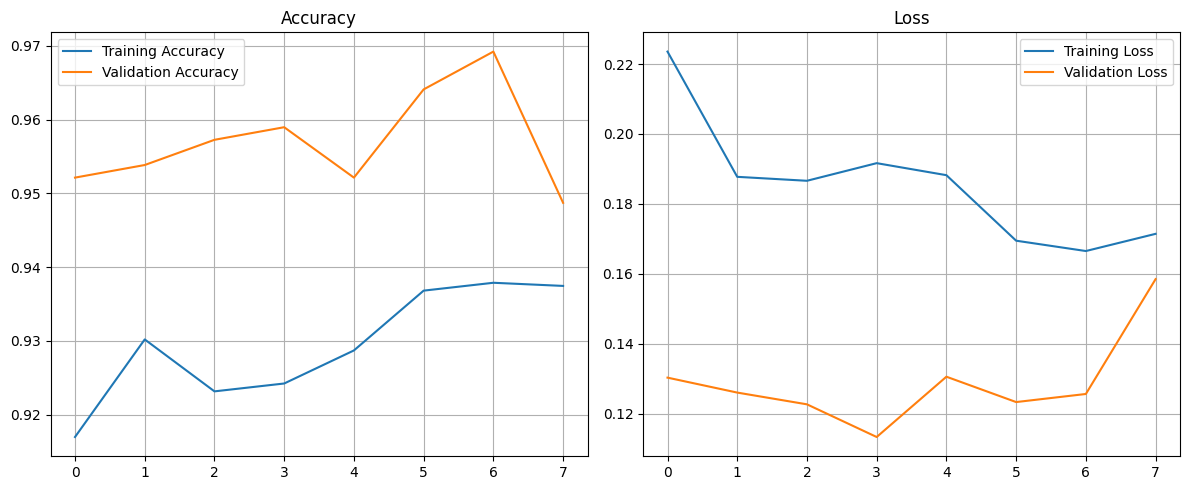

In [25]:
#accuracy and loss plots over epochs
acc1 = history1.history['accuracy']
val_acc1 = history1.history['val_accuracy']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']
epochs_range1 = range(len(acc1))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs_range1, acc1, label='Training Accuracy')
plt.plot(epochs_range1, val_acc1, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(epochs_range1, loss1, label='Training Loss')
plt.plot(epochs_range1, val_loss1, label='Validation Loss')
plt.legend()
plt.grid()
plt.title("Loss")
plt.tight_layout()
plt.show()


19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step

BBest Threshold based on F1 Score: 0.58

Classification Report:
               precision    recall  f1-score   support

      Normal       0.89      0.94      0.91       159
   Pneumonia       0.98      0.96      0.97       428

    accuracy                           0.95       587
   macro avg       0.93      0.95      0.94       587
weighted avg       0.95      0.95      0.95       587



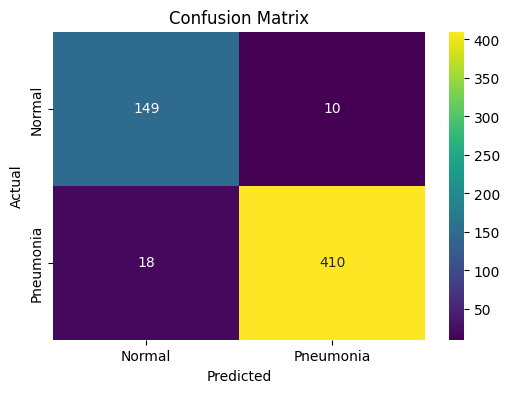

In [26]:
model1 = load_model("best_pneumonia_model1.keras")

# Προβλέψεις
test_generator.reset()
preds1 = model1.predict(test_generator, verbose=1)
y_true1 = test_generator.classes

# Υπολογισμός precision, recall, f1 για διάφορα thresholds
thresholds = np.arange(0.1, 0.9, 0.01)
precisions, recalls, f1s = [], [], []

for t in thresholds:
    y_pred1 = (preds1 > t).astype(int).reshape(-1)
    precisions.append(precision_score(y_true1, y_pred1))
    recalls.append(recall_score(y_true1, y_pred1))
    f1s.append(f1_score(y_true1, y_pred1))

# Βρίσκουμε το threshold που μεγιστοποιεί το F1
best_index = np.argmax(f1s)
best_threshold = thresholds[best_index]
print(f"\nBBest Threshold based on F1 Score: {best_threshold:.2f}")

# Χρησιμοποιούμε αυτό το threshold
y_pred1 = (preds1 > best_threshold).astype(int).reshape(-1)

# Εμφάνιση classification report και confusion matrix
print("\nClassification Report:\n", classification_report(y_true1, y_pred1, target_names=["Normal", "Pneumonia"]))

cm = confusion_matrix(y_true1, y_pred1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="viridis", xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


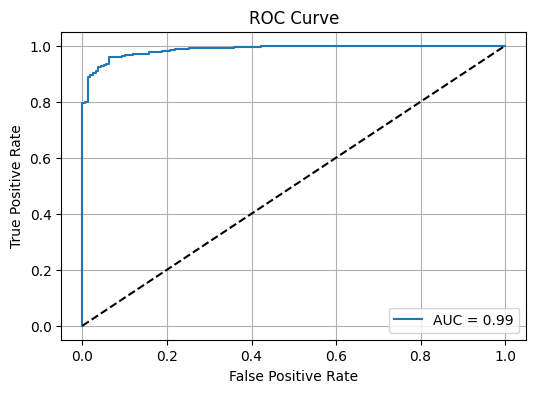

In [28]:
# ROC Curve
fpr, tpr, roc_thresholds = roc_curve(y_true1, preds1)
roc_auc = roc_auc_score(y_true1, preds1)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid()
plt.show()

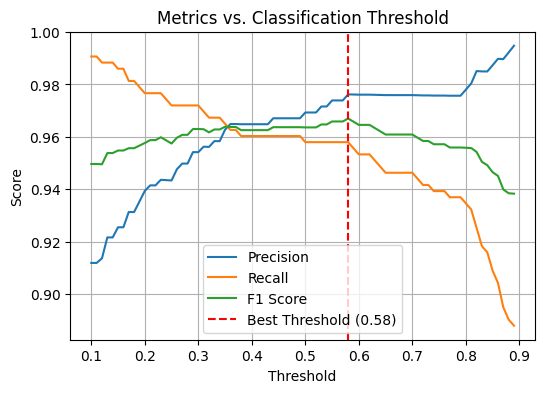

In [29]:
# Γράφημα Precision/Recall/F1 vs Threshold
plt.figure(figsize=(6, 4))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1 Score')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold ({best_threshold:.2f})')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Metrics vs. Classification Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [30]:
print("Running evaluation...")
test_loss, test_accuracy = best_model1.evaluate(test_generator, verbose=1)

Running evaluation...
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step - accuracy: 0.9375 - loss: 0.1640
